Kaggle 에서 데이터 불러오기

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hongjoolee","key":"78a7f6d35e6fd7d34aab00808043355c"}'}

In [ ]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

403 - Forbidden


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=5e2ef42d73b2cb8ec78a7e94046258af80203f1bacdd8a4f98e5a5fdd03c29ab
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c dogs-vs-cats 

 95% 258M/271M [00:02<00:00, 115MB/s]
100% 271M/271M [00:02<00:00, 95.6MB/s]
100% 542M/543M [00:03<00:00, 155MB/s]
100% 543M/543M [00:03<00:00, 158MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 78.8MB/s]


In [ ]:
!unzip -qq train.zip

이미지 로드 
- 훈련, 검증, 테스트로 파일 분할
- 파일을 훈련, 검증, 테스트 데이터로 불러옴

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train") 
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):

  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category 
    os.makedirs(dir) 
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)] 
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000) 
make_subset("validation", start_index=1000, end_index=1500) 
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory( 
    new_base_dir / "train", 
    image_size=(180, 180), 
    batch_size=32) 
validation_dataset = image_dataset_from_directory( 
    new_base_dir / "validation", 
    image_size=(180, 180), 
    batch_size=32) 
test_dataset = image_dataset_from_directory( 
    new_base_dir / "test", 
    image_size=(180, 180), 
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


합성곱 신경망 모형 생성

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers 

inputs = keras.Input(shape=(180, 180, 3)) 
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

모형 컴파일 방안 설정 및 콜백

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

In [ ]:
callbacks = [ 
  keras.callbacks.ModelCheckpoint( 
      filepath="convnet_from_scratch.h5", 
      save_best_only=True, 
      monitor="val_loss") ] 

history = model.fit( 
    train_dataset, 
    epochs=30, 
    validation_data=validation_dataset, 
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 38s 93ms/step - loss: 0.8516 - accuracy: 0.5095 - val_loss: 0.6915 - val_accuracy: 0.5510
Epoch 2/30
63/63 [==============================] - 5s 82ms/step - loss: 0.7077 - accuracy: 0.5265 - val_loss: 0.6799 - val_accuracy: 0.5970
Epoch 3/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6916 - accuracy: 0.5730 - val_loss: 0.6774 - val_accuracy: 0.6050
Epoch 4/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6406 - accuracy: 0.6415 - val_loss: 0.6265 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 5s 80ms/step - loss: 0.6023 - accuracy: 0.6705 - val_loss: 0.6287 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 5s 80ms/step - loss: 0.5860 - accuracy: 0.7040 - val_loss: 0.6037 - val_accuracy: 0.6630
Epoch 7/30
63/63 [==============================] - 5s 80ms/step - loss: 0.5441 - accuracy: 0.7320 - val_loss: 0.6182 - val_accuracy: 0.6370
Epoch 8/30
6

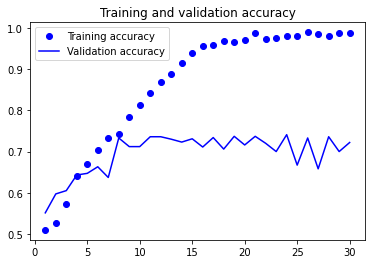

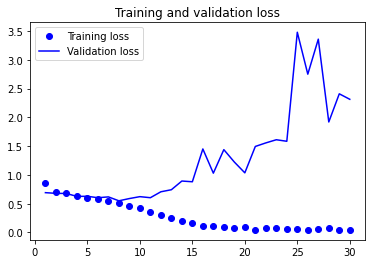

In [ ]:
import matplotlib.pyplot as plt 

accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
epochs = range(1, len(accuracy) + 1) 
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

성과 측정 : 테스트 데이터 

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.h5") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 42ms/step - loss: 0.5891 - accuracy: 0.7015
Test accuracy: 0.701


데이터 증강

In [ ]:
data_augmentation = keras.Sequential( 
    [ 
      layers.experimental.preprocessing.RandomFlip("horizontal"), 
      layers.experimental.preprocessing.RandomRotation(0.1), 
      layers.experimental.preprocessing.RandomZoom(0.2), 
    ] 
)

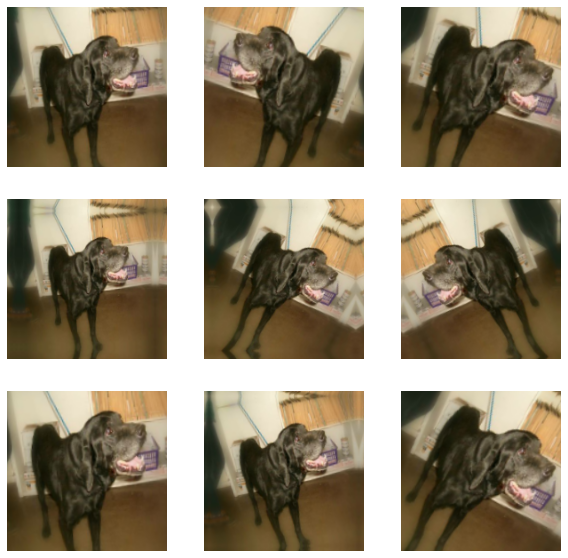

In [ ]:
plt.figure(figsize=(10, 10)) 

for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images) 
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(augmented_images[0].numpy().astype("uint8")) 
    plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(180, 180, 3)) 
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

In [ ]:
callbacks = [ 
  keras.callbacks.ModelCheckpoint( 
      filepath="convnet_from_scratch_with_augmentation.h5", 
      save_best_only=True, 
      monitor="val_loss") ] 

history = model.fit( 
    train_dataset, 
    epochs=30, 
    validation_data=validation_dataset, 
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 84ms/step - loss: 0.7365 - accuracy: 0.4925 - val_loss: 0.6913 - val_accuracy: 0.5710
Epoch 2/30
63/63 [==============================] - 5s 82ms/step - loss: 0.6959 - accuracy: 0.5185 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 5s 82ms/step - loss: 0.6968 - accuracy: 0.5720 - val_loss: 0.6731 - val_accuracy: 0.5640
Epoch 4/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6632 - accuracy: 0.6200 - val_loss: 0.6346 - val_accuracy: 0.6240
Epoch 5/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6205 - accuracy: 0.6755 - val_loss: 0.6207 - val_accuracy: 0.6490
Epoch 6/30
63/63 [==============================] - 5s 81ms/step - loss: 0.5886 - accuracy: 0.6955 - val_loss: 0.6350 - val_accuracy: 0.6850
Epoch 7/30
63/63 [==============================] - 5s 81ms/step - loss: 0.5551 - accuracy: 0.7230 - val_loss: 0.6081 - val_accuracy: 0.6780
Epoch 8/30
63

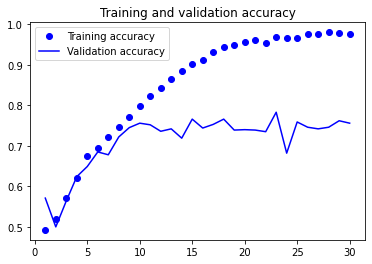

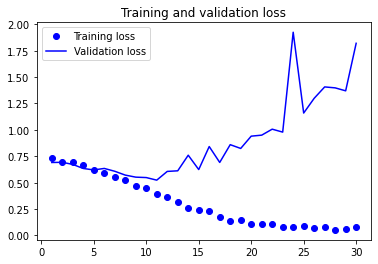

In [ ]:
accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
epochs = range(1, len(accuracy) + 1) 
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.h5") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 42ms/step - loss: 0.5404 - accuracy: 0.7340
Test accuracy: 0.734


In [ ]:
model.save("convnet_from_scratch_with_augmentation.h5")

구글 드라이브에 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
model.save('/content/drive/MyDrive/convnet_from_scratch_with_augmentation.h5')

In [ ]:
test = keras.models.load_model('/content/drive/MyDrive/convnet_from_scratch_with_augmentation.h5')
test.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 128)       7385